# 1Ø vs 2Ø – VPsat, ΔT, S&R (Jupyter Version)

This notebook is a Jupyter-ready conversion of the original Python script. It keeps the same calculations and plotting logic while:

- Using **Markdown** cells for explanations.
- Displaying **SVG** plots inline and saving them to disk.
- Writing results to **Excel** just like the original.



In [14]:
# If needed, install dependencies (uncomment as required)
# !pip install coolprop pandas openpyxl tabulate matplotlib

%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl


In [15]:

from tabulate import tabulate
import math
import os
from pathlib import Path

# Try to import CoolProp (gracefully degrade if not available)
try:
    from CoolProp.CoolProp import PropsSI
    COOLPROP_AVAILABLE = True
except Exception:
    PropsSI = None
    COOLPROP_AVAILABLE = False

# Yield strengths and prices (USD/m³)
MATERIAL_PROPERTIES = {
    "SS304": {"yield_strength": 215, "price_usd_m3": 5250},
    "SS316": {"yield_strength": 205, "price_usd_m3": 6500},
    "Aluminum 6061": {"yield_strength": 276, "price_usd_m3": 6000},
    "Copper": {"yield_strength": 70, "price_usd_m3": 31000},
    "Polyethylene": {"yield_strength": 20, "price_usd_m3": 1400},
    "Polypropylene": {"yield_strength": 25, "price_usd_m3": 1350},
    "Nylon 6": {"yield_strength": 45, "price_usd_m3": 2350},
    "PVC": {"yield_strength": 52, "price_usd_m3": 1700},
    "Titanium": {"yield_strength": 240, "price_usd_m3": 42000},
    "Silver": {"yield_strength": 45, "price_usd_m3": 310000},
    "Gold": {"yield_strength": 205, "price_usd_m3": 961000},
}

Piping_Costing = {
    "material": {"as % of cost": 62.5},
    "installation": {"as % of cost": 17.5},
    "flush&balance": {"as % of cost": 17},
    "other": {"as % of cost": 3}
}

# --- Pump sizing constants ---
PIPE_TOTAL_LENGTH_M = 1000.0  # total loop length for pump sizing (1 km)
MAX_VELOCITY_M_S = 2.0        # max allowable fluid velocity

"""UNIVERSAL VARIABLES"""
T = 25 + 273.15
T_amb = 25 + 273.15
P_amb = 1e5

dT = 10
area = 1
PipeLenghtPerMW = 1
v_limit_liq = 2
Q_liq = 0.0  # to assign density for liquid refrigerant supply

# --- Toggle here ---
Q = 0.5
# Q = 0.8

# --- Toggle here ---
# Direction = "Supply"
Direction = "Return"

# --- Toggle here: choose refrigerant to plot ---
# ref2Plot = "CO2"
# ref2Plot = "R1234ze(E)"
# ref2Plot = "Ammonia"
ref2Plot = "R1233zd(E)"

# --- Toggle here: optionally override max velocity for 2Ø ---
# Max_V_Overwrite = False
Max_V_Overwrite, Max_V_ref = True, 5

# Material pick
PickMaterial = "SS304"
# PickMaterial = "SS316"
# PickMaterial = "Aluminum 6061"
# PickMaterial = "Copper"
# PickMaterial = "Polyethylene"
# PickMaterial = "Polypropylene"
# PickMaterial = "Nylon 6"
# PickMaterial = "PVC"
# PickMaterial = "Titanium"
# PickMaterial = "Silver"
# PickMaterial = "Gold"

SheetName = [f"{PickMaterial} Q={Q} {Direction}", f"PartCost Q={Q}{Direction}"]

# Project-relative output paths (no hard-coded Windows paths)
project_root = Path.cwd()
plots_dir = project_root / "Plots"
output_dir = project_root / "Output"
plots_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Plots → {plots_dir}")
print(f"Output → {output_dir}")


Plots → C:\Users\U375297\Git\Python\EnergySystems\Data Center\Plots
Output → C:\Users\U375297\Git\Python\EnergySystems\Data Center\Output


## Helper functions & correlations
- Material lookups and wall-thickness calc.
- Floating gas-cooler reference pressure utility used for CO₂.

In [16]:
def fetch_yield_strength(material):
    return MATERIAL_PROPERTIES.get(material, {}).get("yield_strength")

def fetch_material_price(material):
    return MATERIAL_PROPERTIES.get(material, {}).get("price_usd_m3")

def calculate_required_thickness(material, pressure_bar, phase, outer_diameter_mm):
    allowable_stress = fetch_yield_strength(material)
    if allowable_stress is None:
        return "Material not found"
    safety_factor = 3 if phase == '1Ø' else 5
    pressure_mpa = pressure_bar / 10
    required_thickness_mm = (pressure_mpa * outer_diameter_mm) / (2 * (allowable_stress / safety_factor))
    return required_thickness_mm

# Floating gas-cooler reference (for CO2 handling)
def FloatingGCref(Tamb, dTgc):
    A0 = 4.81864e7
    A1 = -4.21537e5
    A2 = 9.44047e2
    alpha = 0.1
    Pref = 67e5
    T100 = 39.0 + 273.15
    dTsub = 3
    HRMODE = 0
    if HRMODE < 2:
        T = min(50, max(7, Tamb)) + 273.15
        Tref = ((A1 * A1 - 4.0 * (A0 - Pref) * A2) ** 0.5 - A1) / (2.0 * A2)
        tmp1 = T100 + dTsub
        tmp2 = T100 - Tref
        beta = (1e7 - A0 - (A1 + A2 * tmp1) * tmp1) / (tmp2 + (tmp2 * tmp2 + alpha * alpha) ** 0.5)
        b0 = A0 + (A1 + A2 * dTsub) * dTsub - beta * Tref
        b1 = A1 + 2 * A2 * dTsub + beta
        b2 = A2
        delta = T - Tref
        root = (delta * delta + alpha * alpha) ** 0.5
        P = b0 + (b1 + b2 * T) * T + beta * root
        Sgc_ref = T + dTgc - 273.15
        Pgc_ref = P * 1e-5
        return Sgc_ref, Pgc_ref
    else:
        return None, None

_, P_CO2 = FloatingGCref(T, 1)

## Refrigerant class
Encapsulates property fetches, capacity per area, plotting (SVG), pipe sizing/costing, and hydraulics.
If `CoolProp` is not available, some features will gracefully return placeholders or skip plotting.

In [17]:
class Refrigerant:
    def __init__(self, name, gwp, phase, pfas, Rclass, Vlimit, RCL, material=PickMaterial, pipe_length_m=PipeLenghtPerMW):
        self.name = name
        self.gwp = gwp
        self.phase = phase
        self.pfas = pfas
        self.Rclass = Rclass
        if Max_V_Overwrite and self.phase=="2Ø":
            self.Vlimit = Max_V_ref
        else:
            self.Vlimit = Vlimit
        self.RCL = RCL
        self.material = material
        self.pipe_length_m = pipe_length_m

        self.psat_25C = self.calculate_psat()
        self.pressure_used_bar = self.determine_pressure_used()
        self.pipe_schedule = self.pipe_schedule()
        self.kW_per_m2 = self.calc_kW_per_m2()
        self.area_for_1MW_m2 = self.calculate_area_for_1MW()
        self.pipe_diameter_mm = self.calculate_pipe_diameter()
        self.pipe_thickness_mm = self.calculate_pipe_thickness()
        self.pipe_cost_usd = self.calculate_pipe_cost()
        self.pump_power_kW = self.calculate_pump_power()
        self.mu = self.calc_mu()
        self.rho = self.calc_rho()
        self.sigma = self.calc_surface_tension()
        self.CHF_Zuber = self.calc_chf_zuber()
        self.rho_l_v_rat = self.calc_rho_l_v_rat()

    def calc_mu(self):
        if not COOLPROP_AVAILABLE:
            return None
        if self.phase == '1Ø':
            return PropsSI('VISCOSITY', "T", T_amb, "P", P_amb, self.name)
        elif self.phase == '2Ø':
            return PropsSI('VISCOSITY', 'T', T_amb, 'Q', 0.5, self.name)
        else:
            raise ValueError("Phase must be '1Ø' or '2Ø'")

    def calc_rho(self):
        if not COOLPROP_AVAILABLE:
            return None
        if self.phase == '1Ø':
            return PropsSI("D", "T", T_amb, "P", P_amb, self.name)
        elif self.phase == '2Ø':
            return PropsSI('D', 'T', T_amb, 'Q', 0.5, self.name)
        else:
            raise ValueError("Phase must be '1Ø' or '2Ø'")

    def calc_rho_l_v_rat(self):
        if not COOLPROP_AVAILABLE:
            return None
        if self.phase == '1Ø':
            return 1
        elif self.phase == '2Ø':
            if self.name=="CO2" and T>PropsSI('Tcrit', self.name):
                rho_amb = PropsSI('D', 'P', P_CO2, 'T', T, self.name) / PropsSI('D', 'P', P_CO2, 'T', T+dT, self.name)
            else:
                rho_amb = PropsSI('D', 'T', T, 'Q', 0.0, self.name) / PropsSI('D', 'T', T, 'Q', 1, self.name)
            return rho_amb
        else:
            raise ValueError("Phase must be '1Ø' or '2Ø'")

    def enthalpy_evap_per_kg(self, T_min_C=15.0, T_max_C=50.0, Q_input=None, T_step_C=1.0):
        """Δh(T) = H(T, Q) - H(T, 0.01) in two-phase; else Δh = cp*dT."""
        if not COOLPROP_AVAILABLE:
            raise RuntimeError("CoolProp is required for enthalpy calculations.")

        if Q_input is None:
            try:
                Q_val = Q
            except NameError:
                Q_val = getattr(self, "Q", None)
        else:
            Q_val = Q_input
        if Q_val is None:
            raise ValueError("Q not provided. Pass Q_input or define global Q or self.Q.")
        if not (0.0 <= Q_val <= 1.0):
            raise ValueError(f"Q must be in [0,1]. Got {Q_val}")
        try:
            dT_step = float(dT)
        except NameError:
            dT_step = 10.0

        Tc = PropsSI('Tcrit', self.name)
        Ttriple = PropsSI('Ttriple', self.name)

        try:
            P_used_bar = float(self.pressure_used_bar)
            P_used_Pa = P_used_bar * 1e5
        except Exception:
            try:
                P_used_Pa = float(P_amb)
            except NameError:
                P_used_Pa = 1e5

        if T_min_C > T_max_C:
            T_min_C, T_max_C = T_max_C, T_min_C
        if T_step_C <= 0:
            raise ValueError("T_step_C must be positive.")

        results = []
        Q_base = 0.01
        T_C = T_min_C
        while T_C <= T_max_C + 1e-12:
            T_K = T_C + 273.15
            in_two_phase = (T_K > Ttriple) and (T_K < Tc)

            if in_two_phase:
                if Q_val <= Q_base:
                    delta_h_kJ_per_kg = 0.0
                    mode = 'latent'
                else:
                    try:
                        H_Q = PropsSI('H', 'T', T_K, 'Q', float(Q_val), self.name)
                        H_base = PropsSI('H', 'T', T_K, 'Q', Q_base, self.name)
                        delta_h_kJ_per_kg = max(0.0, (H_Q - H_base) / 1000.0)
                        mode = 'latent'
                    except Exception:
                        cp = PropsSI('Cpmass', 'T', T_K, 'P', P_used_Pa, self.name)
                        delta_h_kJ_per_kg = (cp * dT_step) / 1000.0
                        mode = 'sensible'
                valid_two_phase = True
            else:
                cp = PropsSI('Cpmass', 'T', T_K, 'P', P_used_Pa, self.name)
                delta_h_kJ_per_kg = (cp * dT_step) / 1000.0
                mode = 'sensible'
                valid_two_phase = False

            results.append({
                "T_C": float(T_C),
                "h_0_to_Q_kJ_per_kg": float(delta_h_kJ_per_kg),
                "valid_two_phase": bool(valid_two_phase),
                "mode": mode,
                "Q_base_used": Q_base if mode == 'latent' else None,
            })
            T_C += T_step_C
        return results

    def calc_surface_tension(self):
        if not COOLPROP_AVAILABLE:
            return None
        if "INCOMP" in self.name:
            return None
        elif self.phase == '1Ø':
            return -1
        elif self.phase == '2Ø':
            return PropsSI('SURFACE_TENSION', 'T', T_amb, 'Q', 0.5, self.name)
        else:
            raise ValueError("Phase must be '1Ø' or '2Ø'")

    def calc_chf_zuber(self):
        if not COOLPROP_AVAILABLE:
            return None
        if self.phase != '2Ø':
            return -1
        try:
            h_fg = PropsSI('H', 'T', T_amb, 'Q', 1, self.name) - PropsSI('H', 'T', T_amb, 'Q', 0, self.name)
            rho_l = PropsSI('D', 'T', T_amb, 'Q', 0, self.name)
            rho_v = PropsSI('D', 'T', T_amb, 'Q', 1, self.name)
            sigma = PropsSI('SURFACE_TENSION', 'T', T_amb, 'Q', 0.5, self.name)
            g = 9.81
            C = 0.131
            return C * h_fg * (rho_v ** 0.5) * ((sigma * g * (rho_l - rho_v)) ** 0.25) * (1+rho_v/rho_l)
        except Exception:
            return None

    def calculate_psat(self):
        if not COOLPROP_AVAILABLE:
            return "CoolProp not available"
        try:
            pressure_pa = PropsSI("P", "T", T, "Q", 0, self.name)
            return pressure_pa / 1e5
        except Exception:
            return "N/A"

    # ---- Plot Δh per kg (SVG) ----
    def plot_enthalpy_evap_svg(self, T_min_C=15.0, T_max_C=50.0, T_step_C=1.0, Qs=None,
                               show_tc=True, shade_two_phase=True, figsize=(8, 5),
                               savepath=None, show=True, transparent=True, keep_text_as_text=True,
                               show_pg25_dt10=True, cp_pg25_kJ_per_kgK=3.7, dt_pg25_C=10.0,
                               pg25_style=None, pg25_autoscale=True):
        if not COOLPROP_AVAILABLE:
            print("CoolProp not available; skipping Δh plot for", self.name)
            return None, None
        import matplotlib.pyplot as plt
        from matplotlib import rc_context
        import IPython

        if Qs is None:
            try:
                q_default = float(Q)
            except NameError:
                q_default = getattr(self, "Q", None)
            if q_default is None:
                raise ValueError("Provide Qs, or define global Q or self.Q.")
            Qs = [q_default]
        elif isinstance(Qs, (int, float)):
            Qs = [float(Qs)]
        else:
            Qs = [float(q) for q in Qs]

        rc_updates = {
            "svg.fonttype": "none" if keep_text_as_text else "path",
            "path.simplify": True,
            "path.simplify_threshold": 0.0,
            "axes.titlesize": 12,
            "axes.labelsize": 11,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "legend.fontsize": 10,
        }
        with rc_context(rc_updates):
            fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
            for q in Qs:
                results = self.enthalpy_evap_per_kg(T_min_C=T_min_C, T_max_C=T_max_C, Q_input=q, T_step_C=T_step_C)
                T_C = [r["T_C"] for r in results]
                dh = [r["h_0_to_Q_kJ_per_kg"] for r in results]
                ax.plot(T_C, dh, lw=2, label=f"Q = {q:g}")

            try:
                Tc = PropsSI('Tcrit', self.name) - 273.15
                Ttr = PropsSI('Ttriple', self.name) - 273.15
            except Exception:
                Tc = None
                Ttr = None

            if shade_two_phase and (Tc is not None and Ttr is not None):
                left = max(T_min_C, Ttr)
                right = min(T_max_C, Tc)
                if right > left:
                    ax.axvspan(left, right, color="tab:gray", alpha=0.10, label="Two-phase region")
            if show_tc and (Tc is not None) and (T_min_C <= Tc <= T_max_C):
                ax.axvline(Tc, color="k", ls="--", lw=1.2, alpha=0.7, label="Tcrit")

            if show_pg25_dt10:
                dh_pg25 = cp_pg25_kJ_per_kgK * dt_pg25_C  # kJ/kg
                style = dict(color="tab:green", ls="--", lw=2.0, zorder=5)
                if pg25_style:
                    style.update(pg25_style)
                ax.plot([T_min_C, T_max_C], [dh_pg25, dh_pg25],
                        label=f"PG25 ΔT={dt_pg25_C:g}°C (≈{dh_pg25:.1f} kJ/kg)", **style)
                if pg25_autoscale:
                    ymin, ymax = ax.get_ylim()
                    pad = max(0.05 * (ymax - ymin), 0.5)
                    ax.set_ylim(min(ymin, dh_pg25 - pad), max(ymax, dh_pg25 + pad))

            ax.set_title(f"{self.name}: Δh from Q≈0.01 to Q over Temperature")
            ax.set_xlabel("Temperature [°C]")
            ax.set_ylabel("Δh [kJ/kg]")
            ax.grid(True, which="both", ls=":", alpha=0.5)
            ax.legend(loc="best", frameon=True)

            if transparent:
                fig.patch.set_alpha(0.0)
                ax.set_facecolor((1, 1, 1, 0))

            if savepath:
                if not str(savepath).lower().endswith(".svg"):
                    savepath = str(savepath) + ".svg"
                try:
                    from datetime import datetime, UTC
                except Exception:
                    from datetime import datetime, timezone
                    UTC = timezone.utc  # type: ignore
                metadata = {
                    "Title": f"{self.name} Δh vs T",
                    "Description": f"Δh per kg from Q≈0.01 to Q over {T_min_C}–{T_max_C} °C",
                    "Creator": "Vahid Khorshidi",
                    "Date": datetime.now(UTC).isoformat(),
                }
                fig.savefig(savepath, format="svg", bbox_inches="tight", metadata=metadata, transparent=transparent)

            if show:
                IPython.display.display(fig)
            return fig, ax

    # ---- Plot kW/m² vs T (SVG) ----
    def plot_enthalpy_evap_2_svg(self, T_min_C=15.0, T_max_C=50.0, T_step_C=1.0, Qs=None,
                                 show_tc=True, shade_two_phase=True, figsize=(8, 5),
                                 savepath=None, show=True, transparent=True, keep_text_as_text=True,
                                 dT_C=5.0, area_m2=1.0, Direction="Return", Q_liq=0.01,
                                 P_amb_Pa=101_325.0, P_CO2_bar=80.0, v_limit_liq=None, Vlimit_m_s=None,
                                 show_pg25_dt10=True, cp_pg25_kJ_per_kgK=3.7, rho_pg25_kg_per_m3=1030.0,
                                 dt_pg25_C=10.0, pg25_style=None, v_limit_l=None):
        if not COOLPROP_AVAILABLE:
            print("CoolProp not available; skipping kW/m² plot for", self.name)
            return None, None
        import numpy as np
        import matplotlib.pyplot as plt
        from matplotlib import rc_context
        import IPython

        if Qs is None:
            q_default = getattr(self, "Q", 0.5)
            Qs = [float(q_default)]
        elif isinstance(Qs, (int, float)):
            Qs = [float(Qs)]
        else:
            Qs = [float(q) for q in Qs]

        if Vlimit_m_s is None:
            Vlimit_m_s = getattr(self, "Vlimit", 0.5)

        rc_updates = {
            "svg.fonttype": "none" if keep_text_as_text else "path",
            "path.simplify": True,
            "path.simplify_threshold": 0.0,
            "axes.titlesize": 12,
            "axes.labelsize": 11,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "legend.fontsize": 10,
        }

        def frange(start, stop, step):
            vals = []
            x = start
            while x <= stop + 1e-9:
                vals.append(x)
                x += step
            return vals

        def _explicit_kw_per_m2(T_C: float, Q: float):
            name = self.name
            phase = getattr(self, "phase", "2Ø")
            T_K = T_C + 273.15
            dT_loc = dT_C
            P_CO2 = P_CO2_bar
            Vlimit = Vlimit_m_s
            if phase == "1Ø" and name in ["INCOMP::MEG-25%", "Water"]:
                cp = PropsSI("C", "T", T_K + dT_loc / 2.0, "P", P_amb_Pa, name)  # J/(kg·K)
                rho = PropsSI("D", "T", T_K, "P", P_amb_Pa, name)  # kg/m³
                cooling_power_W = area_m2 * Vlimit * rho * cp * dT_loc
                return cooling_power_W / 1000.0 / area_m2
            if phase == "2Ø":
                try:
                    Tc = PropsSI('Tcrit', name)
                except Exception:
                    Tc = None
                if Tc is None or T_K < Tc - 1:  # subcritical two-phase
                    if Direction == "Supply":
                        rho = PropsSI("D", "T", T_K, "Q", Q_liq, name)
                        volumetric_flow = (v_limit_liq if v_limit_liq is not None else Vlimit) * area_m2
                    else:
                        rho = PropsSI("D", "T", T_K, "Q", Q, name)
                        volumetric_flow = Vlimit * area_m2
                    mass_flow = rho * volumetric_flow
                    H_Q = PropsSI("H", "T", T_K, "Q", Q, name)
                    H_001 = PropsSI("H", "T", T_K, "Q", 0.01, name)
                    delta_h = H_Q - H_001
                    cooling_power_W = mass_flow * delta_h
                else:
                    P_CO2_Pa = P_CO2 * 1e5
                    if Direction == "Supply":
                        rho = PropsSI("D", "T", T_K, "P", P_CO2_Pa, name)
                        volumetric_flow = Vlimit * area_m2
                    else:
                        rho = PropsSI("D", "T", T_K + dT_loc, "P", P_CO2_Pa, name)
                        volumetric_flow = Vlimit * area_m2
                    mass_flow = rho * volumetric_flow
                    H_out = PropsSI("H", "T", T_K + dT_loc, "P", P_CO2_Pa, name)
                    H_in  = PropsSI("H", "T", T_K,           "P", P_CO2_Pa, name)
                    delta_h = H_out - H_in
                    cooling_power_W = mass_flow * delta_h
                return cooling_power_W / 1000.0 / area_m2
            return None

        def _call_user_calc_kw_per_m2(T_C: float, Q: float):
            if not hasattr(self, "calc_kW_per_m2"):
                return _explicit_kw_per_m2(T_C, Q)
            fn = self.calc_kW_per_m2
            g = fn.__globals__
            keys = ["T", "dT", "area", "Direction", "Q", "Q_liq", "P_amb", "P_CO2", "v_limit_liq"]
            stash = {k: g[k] for k in keys if k in g}
            try:
                g["T"] = T_C + 273.15
                g["dT"] = dT_C
                g["area"] = area_m2
                g["Direction"] = Direction
                g["Q"] = Q
                g["Q_liq"] = Q_liq
                g["P_amb"] = P_amb_Pa
                g["P_CO2"] = P_CO2_bar
                g["v_limit_liq"] = v_limit_liq
                if getattr(self, "Vlimit", None) is None and Vlimit_m_s is not None:
                    setattr(self, "Vlimit", Vlimit_m_s)
                val = fn()  # kW total
                if val is None:
                    return None
                return float(val) / float(area_m2)
            except Exception:
                return _explicit_kw_per_m2(T_C, Q)
            finally:
                for k in keys:
                    if k in stash:
                        g[k] = stash[k]
                    elif k in g:
                        del g[k]

        with rc_context(rc_updates):
            fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
            Ts = frange(T_min_C, T_max_C, T_step_C)
            for Q_ in Qs:
                ys = []
                for T_C in Ts:
                    y = _call_user_calc_kw_per_m2(T_C, Q_)  # kW/m²
                    import numpy as np
                    ys.append(y if y is not None else np.nan)
                ax.plot(Ts, ys, lw=2, label=f"Q={Q_:g}, ΔT={dT_C:g}°C, {Direction}")

            try:
                Tc = PropsSI('Tcrit', self.name) - 273.15
                Ttr = PropsSI('Ttriple', self.name) - 273.15
            except Exception:
                Tc = None
                Ttr = None
            if shade_two_phase and (Tc is not None and Ttr is not None):
                left = max(T_min_C, Ttr)
                right = min(T_max_C, Tc)
                if right > left:
                    ax.axvspan(left, right, color="tab:gray", alpha=0.10, label="Two-phase region")
            if show_tc and (Tc is not None) and (T_min_C <= Tc <= T_max_C):
                ax.axvline(Tc, color="k", ls="--", lw=1.2, alpha=0.7, label="Tcrit")

            if show_pg25_dt10:
                V_for_pg = v_limit_l if v_limit_l is not None else v_limit_liq
                kwm2_pg25 = rho_pg25_kg_per_m3 * V_for_pg * cp_pg25_kJ_per_kgK * dt_pg25_C
                style = dict(color="tab:green", ls="--", lw=2.0, zorder=5)
                if pg25_style:
                    style.update(pg25_style)
                ax.plot([T_min_C, T_max_C], [kwm2_pg25, kwm2_pg25],
                        label=f"PG25 ΔT={dt_pg25_C:g}°C (≈{kwm2_pg25:.1f} kW/m²)", **style)
                ymin, ymax = ax.get_ylim()
                pad = max(0.05 * (ymax - ymin), 0.5)
                ax.set_ylim(min(ymin, kwm2_pg25 - pad), max(ymax, kwm2_pg25 + pad))

            ax.set_title(f"{self.name}: Cooling capacity per area vs Temperature")
            ax.set_xlabel("Temperature [°C]")
            ax.set_ylabel("Cooling capacity [kW/m²]")
            ax.grid(True, which="both", ls=":", alpha=0.5)
            ax.legend(loc="best", frameon=True)

            if transparent:
                fig.patch.set_alpha(0.0)
                ax.set_facecolor((1, 1, 1, 0))

            if savepath:
                if not str(savepath).lower().endswith(".svg"):
                    savepath = str(savepath) + ".svg"
                try:
                    from datetime import datetime, UTC
                except Exception:
                    from datetime import datetime, timezone
                    UTC = timezone.utc  # type: ignore
                metadata = {
                    "Title": f"{self.name} kW/m² vs T",
                    "Description": f"Cooling capacity per area over {T_min_C}–{T_max_C} °C",
                    "Creator": "Vahid Khorshidi",
                    "Date": datetime.now(UTC).isoformat(),
                }
                fig.savefig(savepath, format="svg", bbox_inches="tight", metadata=metadata, transparent=transparent)

            IPython.display.display(fig)
            return fig, ax

    def determine_pressure_used(self):
        if "water" in self.name.lower():
            return 3.0
        elif self.phase == "1Ø":
            return 3.0
        else:
            return self.psat_25C if isinstance(self.psat_25C, (int, float)) else P_CO2

    def pipe_schedule(self):
        if self.pressure_used_bar < 10:
            return "40"
        else:
            return "80"

    def calc_kW_per_m2(self):
        if not COOLPROP_AVAILABLE:
            return None
        if self.phase == "1Ø" and self.name in ["INCOMP::MEG-25%", "Water"]:
            cp = PropsSI("C", "T", T + dT / 2, "P", P_amb, self.name)
            rho = PropsSI("D", "T", T, "P", P_amb, self.name)
            cooling_power = area * self.Vlimit * rho * cp * dT
            return cooling_power / 1000
        if self.phase == "2Ø":
            if T < PropsSI('Tcrit', self.name)-1:
                if Direction == "Supply":
                    rho = PropsSI("D", "T", T, "Q", Q_liq, self.name)
                    volumetric_flow = v_limit_liq * area
                else:
                    rho = PropsSI("D", "T", T, "Q", Q, self.name)
                    volumetric_flow = self.Vlimit * area
                mass_flow = rho * volumetric_flow
                delta_h = PropsSI("H", "T", T, "Q", Q, self.name) - PropsSI("H", "T", T, "Q", 0.01, self.name)
                cooling_power = mass_flow * delta_h
            else:
                if Direction == "Supply":
                    rho = PropsSI("D", "T", T, "P", P_CO2*1e5, self.name)
                    volumetric_flow = self.Vlimit * area
                else:
                    rho = PropsSI("D", "T", T+dT, "P", P_CO2*1e5, self.name)
                    volumetric_flow = self.Vlimit * area
                mass_flow = rho * volumetric_flow
                delta_h = PropsSI("H", "T", T+dT, "P", P_CO2*1e5, self.name) - PropsSI("H", "T", T, "P", P_CO2*1e5, self.name)
                cooling_power = mass_flow * delta_h
            return cooling_power / 1000
        return None

    def calculate_area_for_1MW(self):
        try:
            if isinstance(self.kW_per_m2, (int, float)) and self.kW_per_m2 > 0:
                return 1000 / self.kW_per_m2
            else:
                return "N/A"
        except Exception:
            return "N/A"

    def calculate_pipe_diameter(self):
        try:
            if isinstance(self.area_for_1MW_m2, (int, float)):
                diameter_m = math.sqrt(4 * self.area_for_1MW_m2 / math.pi)
                return diameter_m * 1000
            else:
                return "N/A"
        except Exception:
            return "N/A"

    def calculate_pipe_thickness(self):
        try:
            if isinstance(self.pipe_diameter_mm, (int, float)):
                return calculate_required_thickness(self.material, self.pressure_used_bar, self.phase, self.pipe_diameter_mm)
            else:
                return "N/A"
        except Exception as e:
            return f"Error: {e}"

    def interpolateDNShedule(self):
        schedule_40 = [
            (0.005588, 2.2), (0.00762, 2.5), (0.010668, 3.230769231), (0.01397, 3.666666667),
            (0.018796, 4.933333333), (0.024384, 5.333333333), (0.032512, 6.736842105),
            (0.0381, 7.5), (0.049276, 8.818181818), (0.058928, 8.285714286),
            (0.07366, 9.666666667), (0.085344, 10.5), (0.097282, 11.26470588),
            (0.122174, 12.65789474), (0.146304, 13.39534884), (0.193802, 15.26),
            (0.242824, 16.20338983), (0.289052, 16.49275362), (0.3175, 16.66666667),
            (0.363474, 17.03571429), (0.409702, 17.15957447), (0.455676, 17.41747573),
            (0.547624, 17.67213115)
        ]
        schedule_80 = [
            (0.006858, 3.857142857), (0.009144, 4), (0.012446, 5.444444444),
            (0.015748, 5.636363636), (0.020828, 7.454545455), (0.02667, 8.076923077),
            (0.035052, 9.857142857), (0.040894, 10.73333333), (0.052578, 13.8),
            (0.062738, 12.35), (0.077978, 13.95454545), (0.09017, 15.43478261),
            (0.102362, 16.79166667), (0.12827, 19.42307692), (0.154178, 21.67857143),
            (0.202692, 24.9375), (0.254508, 27.08108108), (0.303276, 29.12195122),
            (0.333502, 29.84090909), (0.381, 30), (0.428752, 30.14285714),
            (0.477774, 31.88135593), (0.574802, 32.79710145)
        ]
        dataset = schedule_40 if self.pipe_schedule == '40' else schedule_80 if self.pipe_schedule == '80' else None
        if dataset is None:
            raise ValueError("Invalid schedule type. Use '40' or '80'.")
        diameter = float(self.pipe_diameter_mm)/1000
        for x, y in dataset:
            if diameter == x:
                return y
        for i in range(len(dataset) - 1):
            x0, y0 = dataset[i]
            x1, y1 = dataset[i + 1]
            if x0 <= diameter <= x1:
                return y0 + (diameter - x0) * (y1 - y0) / (x1 - x0)
        if diameter < dataset[0][0]:
            x0, y0 = dataset[0]
            x1, y1 = dataset[1]
        elif diameter > dataset[-1][0]:
            x0, y0 = dataset[-2]
            x1, y1 = dataset[-1]
        else:
            raise ValueError("Unexpected error during extrapolation.")
        return y0 + (diameter - x0) * (y1 - y0) / (x1 - x0)

    def calculate_pipe_cost(self):
        try:
            price_per_m3 = fetch_material_price(self.material)
            if price_per_m3 is None or not isinstance(self.pipe_diameter_mm, (int, float)) or not isinstance(self.interpolateDNShedule(), (int, float)):
                return "N/A"
            outer_radius_m = self.pipe_diameter_mm / 2000
            inner_radius_m = outer_radius_m - (self.interpolateDNShedule() / 1000)
            cross_section_area_m2 = math.pi * (outer_radius_m**2 - inner_radius_m**2)
            volume_m3 = cross_section_area_m2 * self.pipe_length_m
            cost = volume_m3 * price_per_m3
            return cost*2
        except Exception:
            return "N/A"

    # Friction/roughness helpers
    def _roughness_from_material(self, fallback: float = 4.5e-5) -> float:
        mat = str(getattr(self, "material", "")).strip().lower()
        map_exact = {
            "ss304": 1.5e-5, "ss316": 1.5e-5, "copper": 1.5e-5, "aluminum 6061": 1.5e-5,
            "polyethylene": 5.0e-6, "polypropylene": 5.0e-6, "nylon 6": 5.0e-6,
            "pvc": 1.5e-6, "titanium": 1.5e-5
        }
        map_keywords = {"stainless": 1.5e-5, "steel": 4.5e-5, "hdpe": 5.0e-6, "pe": 5.0e-6, "cpvc": 2.0e-6, "smooth": 1.0e-6}
        if mat in map_exact: return map_exact[mat]
        for k, v in map_keywords.items():
            if k in mat: return v
        return fallback

    def _friction_factor(self, Re: float, rel_eps: float, method: str = "churchill") -> float:
        import math
        def f_churchill(Re, rel_eps):
            term = (7.0 / Re) ** 0.9 + 0.27 * rel_eps
            term = max(term, 1e-12)
            A = (2.457 * math.log(1.0 / term)) ** 16
            B = (37530.0 / Re) ** 16
            return 8.0 * (((8.0 / Re) ** 12) + 1.0 / ((A + B) ** 1.5)) ** (1.0 / 12.0)
        def f_haaland(Re, rel_eps):
            inner = (rel_eps / 3.7) ** 1.11 + 6.9 / Re
            inner = max(inner, 1e-12)
            return 1.0 / (-1.8 * math.log10(inner)) ** 2
        if Re < 2300:
            return max(64.0 / max(Re, 1e-12), 1e-8)
        return max((f_haaland if method.lower() == "haaland" else f_churchill)(Re, rel_eps), 1e-8)

    def _infer_mu_rho_for_hydraulics(self, use_liquid_for_2phase: bool = True):
        if not COOLPROP_AVAILABLE:
            raise ValueError("CoolProp not available to infer μ and ρ.")
        if self.phase == "1Ø":
            rho = PropsSI("D", "T", T, "P", P_amb, self.name)
            mu = PropsSI("V", "T", T, "P", P_amb, self.name)  # Pa·s
            return mu, rho
        if self.phase == "2Ø":
            if use_liquid_for_2phase:
                rho = PropsSI("D", "T", T, "Q", 0.0, self.name)
                mu = PropsSI("V", "T", T, "Q", 0.0, self.name)
                return mu, rho
            else:
                q_use = Q if Direction != "Supply" else Q_liq
                q_use = min(max(q_use, 0.0), 1.0)
                rho = PropsSI("D", "T", T, "Q", q_use, self.name)
                mu = PropsSI("V", "T", T, "Q", q_use, self.name)
                return mu, rho
        raise ValueError(f"Unsupported phase '{self.phase}' for μ/ρ inference.")

    def calculate_pump_power(self, pump_efficiency: float = 0.70, return_components: bool = False, diameter_mm: float = None, velocity_m_per_s: float = None):
        import math
        if not isinstance(self.pipe_diameter_mm, (int, float)):
            raise ValueError("Pipe diameter for 1 MW not calculated.")
        D = self.pipe_diameter_mm / 1000.0
        area_m2 = math.pi * (D ** 2) / 4.0
        if not isinstance(self.kW_per_m2, (int, float)) or self.kW_per_m2 <= 0:
            raise ValueError("kW_per_m2 not calculated or invalid.")
        velocity_calc = (1000.0 / self.kW_per_m2) / self.area_for_1MW_m2
        volumetric_flow_m3_s = velocity_calc * area_m2
        mu_Pa_s, rho_kg_m3 = self._infer_mu_rho_for_hydraulics()
        roughness_m = self._roughness_from_material()
        Re = rho_kg_m3 * velocity_calc * D / mu_Pa_s
        f = self._friction_factor(Re, roughness_m / D, "churchill")
        length_m = 1000.0
        dynamic_head = 0.5 * rho_kg_m3 * velocity_calc ** 2
        delta_p_major = f * (length_m / D) * dynamic_head
        delta_p_minor = 0.0
        delta_p_total = delta_p_major + delta_p_minor
        P_hyd_W = delta_p_total * volumetric_flow_m3_s
        P_shaft_W = P_hyd_W / max(min(pump_efficiency, 0.9999), 1e-6)
        result = {
            "mu_Pa_s": mu_Pa_s,
            "rho_kg_m3": rho_kg_m3,
            "Re": Re,
            "friction_factor": f,
            "velocity_m_per_s": velocity_calc,
            "volumetric_flow_m3_s": volumetric_flow_m3_s,
            "delta_p_major_Pa": delta_p_major,
            "delta_p_minor_Pa": delta_p_minor,
            "delta_p_total_Pa": delta_p_total,
            "length_m": length_m,
            "hydraulic_power_kW": P_hyd_W / 1000.0,
            "shaft_power_kW": P_shaft_W / 1000.0,
            "diameter_m": D,
            "roughness_m": roughness_m,
        }
        return result if return_components else result["shaft_power_kW"]

## Define refrigerants & run
Creates the refrigerant objects, generates the plots (SVG **displayed and saved**), builds the comparison table, and exports to Excel.

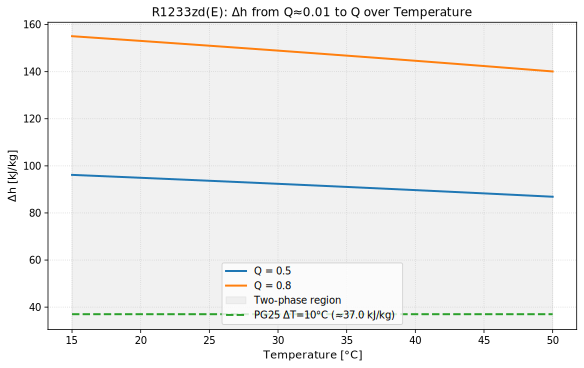

Error with refrigerant 'R1233zd(E)': unsupported operand type(s) for *: 'float' and 'NoneType'


In [22]:
# Create refrigerant objects
refrigerants = [
    # 1Ø
    Refrigerant('INCOMP::MEG-25%', 0, "1Ø", "No", "A1", v_limit_liq, "N/A"),
    Refrigerant("Water", 0, "1Ø", "No", "A1", v_limit_liq, "N/A"),
    # 2Ø (natural & low/med GWP)
    Refrigerant("CO2", 1, "2Ø", "No", "A1", 10.0, 35.8),
    Refrigerant("Ammonia", 1.37, "2Ø", "No", "B2L", 25.0, 0),
    Refrigerant("R290", 0.02, "2Ø", "No", "A3", 18.0, 8),
    Refrigerant("Water", 0, "2Ø", "No", "A1", 30.0, "N/A"),
    Refrigerant("R1234ze(E)", 1.37, "2Ø", "Yes", "A2L", 20.0, 76),
    Refrigerant("R1233zd(E)", 1, "2Ø", "No", "B1", 20.0, 75),
    Refrigerant("R152a", 124, "2Ø", "Yes", "A2", 20.0, 280),
    Refrigerant("R32", 675, "2Ø", "Yes", "A2L", 20.0, 77),
    Refrigerant("R134a", 1430, "2Ø", "Yes", "A1", 20.0, 210),
]

# Normalization anchor (Water 1Ø)
normalized_pipe_cost_water = 0
for r in refrigerants:
    if r.name == "Water" and r.phase == "1Ø":
        normalized_pipe_cost_water = r.pipe_cost_usd

# Headers depend on Direction
if Direction == "Supply":
    headers = [
        "Media", "t CO2 eq.", "2Ø / 1Ø", "PFAS", "Ref. Class", "RCL [gr./m3]",
        "Psat@25°C", "Visc@25°C", "Dens@25°C", "SurfTens@25°C", "CritHF@25°C",
        "V_lim liq.", "Liq. rho", "P_@calc(bar)", "Pipe Schedule", "Working fluid",
        "Cool. cap. / d_pipe [MW/m²] Liq", "Pipe Diameter (mm)", "Pipe Thickness Theoretical (mm)",
        "Pipe Thickness ANSI (mm)", f"Pipe Tot. Cost for *{PickMaterial}* (USD, 1m)", "Normalized cost",
        "Pump kW/1MW_cooling (Eta = 0.7)"
    ]
else:
    headers = [
        "Media", "t CO2 eq.", "2Ø / 1Ø", "PFAS", "Ref. Class", "RCL [gr./m3]",
        "Psat@25°C", "Visc@25°C", "Dens@25°C", "SurfTens@25°C", "CritHF@25°C",
        "V_lim Vap (L, 2Ø)", "L/V rho", "P_@calc(bar)", "Pipe Schedule", "Working fluid",
        "Cool. cap. / d_pipe [MW/m²] V+L", "Pipe Diameter (mm)", "Pipe Thickness Theoretical (mm)",
        "Pipe Thickness ANSI (mm)", f"Pipe Tot. Cost for *{PickMaterial}* (USD, 1m)", "Normalized cost"
    ]

table_data = []

# Plotting only for the chosen 2Ø medium
for r in refrigerants:
    try:
        # Save+show SVG plots for selected fluid
        if COOLPROP_AVAILABLE and r.phase == "2Ø" and r.name == ref2Plot:
            save1 = plots_dir / f"enthalpy_evap_{r.name}_V={r.Vlimit}.svg"
            r.plot_enthalpy_evap_svg(T_min_C=15, T_max_C=50, Qs=[0.5, 0.8], savepath=str(save1), transparent=True, keep_text_as_text=True)

            save2 = plots_dir / f"enthalpy_evap_2_{r.name}_V={r.Vlimit}.svg"
            r.plot_enthalpy_evap_2_svg(T_min_C=15, T_max_C=50, Qs=[0.5, 0.8], savepath=str(save2), transparent=True, keep_text_as_text=True)

        # Row build
        if Direction == "Supply":
            row = [
                r.name, r.gwp, r.phase, r.pfas, r.Rclass, r.RCL,
                r.psat_25C, r.calc_mu(), r.calc_rho(), r.calc_surface_tension(), r.calc_chf_zuber(),
                f"{r.Vlimit} ({v_limit_liq}, {round(r.Vlimit/3, 0)})", r.calc_rho_l_v_rat(),
                r.pressure_used_bar, r.pipe_schedule, r.name,
                None if r.kW_per_m2 is None else r.kW_per_m2 / 1000,
                r.pipe_diameter_mm, r.pipe_thickness_mm, r.interpolateDNShedule(),
                None if r.pipe_cost_usd == "N/A" else r.pipe_cost_usd / (Piping_Costing.get("material", {}).get("as % of cost")/100),
                None if normalized_pipe_cost_water in (0, "N/A") else (r.pipe_cost_usd / normalized_pipe_cost_water),
                r.pump_power_kW,
            ]
        else:
            row = [
                r.name, r.gwp, r.phase, r.pfas, r.Rclass, r.RCL,
                r.psat_25C, r.calc_mu(), r.calc_rho(), r.calc_surface_tension(), r.calc_chf_zuber(),
                f"{r.Vlimit} ({v_limit_liq}, {round(r.Vlimit/3, 0)})", r.calc_rho_l_v_rat(),
                r.pressure_used_bar, r.pipe_schedule, r.name,
                None if r.kW_per_m2 is None else r.kW_per_m2 / 1000,
                r.pipe_diameter_mm, r.pipe_thickness_mm, r.interpolateDNShedule(),
                None if r.pipe_cost_usd == "N/A" else r.pipe_cost_usd / (Piping_Costing.get("material", {}).get("as % of cost")/100),
                None if normalized_pipe_cost_water in (0, "N/A") else (r.pipe_cost_usd / normalized_pipe_cost_water),
            ]
        table_data.append(row)
    except (TypeError, AttributeError) as e:
        print(f"Error with refrigerant '{getattr(r,'name','Unknown')}': {e}")
        continue

# print(tabulate(table_data, headers=headers, tablefmt="grid", colalign=("center",)*len(headers)))


In [21]:
print(tabulate(table_data, headers=headers, tablefmt="grid", colalign=("center",)*len(headers)))

+-----------------+-------------+-----------+--------+--------------+----------------+-------------+-------------+-------------+-----------------+---------------+---------------------+-----------+----------------+-----------------+-----------------+-----------------------------------+----------------------+-----------------------------------+----------------------------+----------------------------------------+-------------------+
|      Media      |  t CO2 eq.  |  2Ø / 1Ø  |  PFAS  |  Ref. Class  |  RCL [gr./m3]  |  Psat@25°C  |  Visc@25°C  |  Dens@25°C  |  SurfTens@25°C  |  CritHF@25°C  |  V_lim Vap (L, 2Ø)  |  L/V rho  |  P_@calc(bar)  |  Pipe Schedule  |  Working fluid  |  Cool. cap. / d_pipe [MW/m²] V+L  |  Pipe Diameter (mm)  |  Pipe Thickness Theoretical (mm)  |  Pipe Thickness ANSI (mm)  |  Pipe Tot. Cost for *SS304* (USD, 1m)  |  Normalized cost  |
+=================+=============+===========+========+==============+================+=============+=============+=============+==

## Export to Excel
Writes the main comparison table into `Output/3 - 1Øvs2Ø.xlsx`.


In [19]:
import pandas as pd

# Save the main table
df_main = pd.DataFrame(table_data, columns=headers)
excel_path = output_dir / "3 - 1Øvs2Ø.xlsx"
print(f"\nExcel file target: {excel_path}")

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a' if excel_path.exists() else 'w', if_sheet_exists='replace') as writer:
    df_main.to_excel(writer, sheet_name=SheetName[0], index=False)
print("Main table exported.")



Excel file target: C:\Users\U375297\Git\Python\EnergySystems\Data Center\Output\3 - 1Øvs2Ø.xlsx
Main table exported.


## Component costing (normalized)
Adjust unit prices/quantities below. The last row shows totals normalized by each refrigerant's pipe cost (retains material-share normalization).


In [20]:
# Component data: (name, unit price EUR, quantity or length)
components = [
    ("DN100 Pipe", 40, 35),
    ("DN50 Hose", 200, 64),
    ("T-Joints", 40, 32),
    ("Elbows DN100", 30, 4),
    ("Main Isolation Valves DN100", 1000, 8),
    ("Rack Isolation Valves DN50", 150, 32),
    ("Weld Neck Flanges DN100", 150, 8)
]

# Determine normalized pipe cost for water (1Ø)
normalized_pipe_cost_water = next((r.pipe_cost_usd for r in refrigerants if r.name == "Water" and r.phase=="1Ø"), 1)

# Prepare table data
comp_table = []
comp_total = 0
for name, unit_price, quantity in components:
    cost = unit_price * quantity
    comp_total += cost
    row = [name, unit_price, quantity, cost]
    for r in refrigerants:
        normalized_factor = (r.pipe_cost_usd / normalized_pipe_cost_water) if normalized_pipe_cost_water not in (0, "N/A") else None
        row.append(None if normalized_factor is None else cost * normalized_factor)
    comp_table.append(row)

# Add total cost row (normalized by material share like original)
total_row = [f"Total based on *{PickMaterial}*", "", "", comp_total]
for r in refrigerants:
    material_share = Piping_Costing.get("material", {}).get("as % of cost")/100
    normalized_factor = (r.pipe_cost_usd / normalized_pipe_cost_water / material_share) if normalized_pipe_cost_water not in (0, "N/A") else None
    total_row.append(None if normalized_factor is None else comp_total * normalized_factor)
comp_table.append(total_row)

# Define headers
comp_headers = ["Component", "Unit Price (EUR)", "Quantity/Length", "Total(EUR)"]
comp_headers += [f"({r.name})" for r in refrigerants]

print(tabulate(comp_table, headers=comp_headers, tablefmt="grid"))

# Save to Excel (second sheet)
df_comp = pd.DataFrame(comp_table, columns=comp_headers)
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_comp.to_excel(writer, sheet_name=SheetName[1], index=False)


+-----------------------------+--------------------+-------------------+--------------+---------------------+-----------+-----------+-------------+-----------+------------------+----------------+----------------+------------+-----------+------------+
| Component                   | Unit Price (EUR)   | Quantity/Length   |   Total(EUR) |   (INCOMP::MEG-25%) |   (Water) |     (CO2) |   (Ammonia) |    (R290) |          (Water) |   (R1234ze(E)) |   (R1233zd(E)) |    (R152a) |     (R32) |    (R134a) |
+=============================+====================+===================+==============+=====================+===========+===========+=============+===========+==================+================+================+============+===========+============+
| DN100 Pipe                  | 40                 | 35                |         1400 |            1453.73  |      1400 |  1603.08  |    3332.41  |  2780.83  |  46696.3         |       3704.02  |       7194.12  |   3330.34  |  2599.95  |   3111.59

## Notes
- Plots are saved as **SVG** in the `Plots/` folder and also rendered inline.
- Tables are saved to `Output/3 - 1Øvs2Ø.xlsx` in two sheets named from `SheetName`.
- If `CoolProp` is not installed, property-dependent features are skipped or return placeholders. Install it and re-run for full functionality.